## Approach B

### Data path
You need to set this up yourself. 

## Data (not augmented)

This section introduces the data handling approach for the project.
The code defines a custom PyTorch Dataset class, `AccentSpectrogramDataset`, which loads audio files from a specified folder,
applies optional mel-spectrogram transformations, and returns the resulting spectrogram along with the accent label and gender extracted from the filename. This dataset is designed to be used for training or evaluating models
on accent classification tasks using spectrogram representations of audio.


In [1]:
import os
import torch
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset

class AccentSpectrogramDataset(Dataset):
    def __init__(self, folder_path,
                 target_sr: int = 16000,
                 use_mel: bool = False,
                 n_fft: int = 400,
                 hop_length: int = None,
                 n_mels: int = 64,
                 log_scale: bool = True):
        # store file paths only; transform per item
        self.file_paths = [
            os.path.join(folder_path, f)
            for f in os.listdir(folder_path)
            if f.endswith('.wav')
        ]
        self.target_sr = target_sr
        self.use_mel = use_mel
        self.n_fft = n_fft
        self.hop_length = hop_length or n_fft // 2
        self.n_mels = n_mels
        self.log_scale = log_scale

        # pre-configure transform funct
        if self.use_mel:
            self._transform = lambda w: T.MelSpectrogram(
                sample_rate=self.target_sr,
                n_fft=self.n_fft,
                hop_length=self.hop_length,
                n_mels=self.n_mels
            )(w)
        else:
            self._transform = lambda w: T.Spectrogram(
                n_fft=self.n_fft,
                hop_length=self.hop_length
            )(w)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        waveform, sr = torchaudio.load(path)
        if sr != self.target_sr:
            waveform = T.Resample(sr, self.target_sr)(waveform)

        spec = self._transform(waveform)
        if self.log_scale:
            spec = torch.log(spec + 1e-6)

        fname = os.path.basename(path)
        accent = int(fname[0]) - 1          # classes 0–4
        gender = fname[1]  # 'm' or 'f' 
        return spec, accent, gender

### Pad_collate

This section defines a custom collate function called `pad_collate` for use with a PyTorch DataLoader.
The function takes a batch of tuples (each containing a spectrogram, accent label, and gender),
pads or crops each spectrogram in the batch to a fixed width (`target_width`, default 208),
and returns a batch of stacked spectrogram tensors, a tensor of accent labels, and a list of gender strings.
This ensures that all spectrograms in a batch have the same shape, which is required for efficient batching in PyTorch.


In [2]:
import torch.nn.functional as F
def pad_collate(batch, target_width=208):
    specs, accents, genders = zip(*batch)
    padded_specs = []
    for s in specs:
        pad_amount = target_width - s.shape[-1]
        if pad_amount > 0:
            padded = torch.nn.functional.pad(s, (0, pad_amount))
        else:
            padded = s[..., :target_width]
        padded_specs.append(padded)
    return (
        torch.stack(padded_specs),
        torch.tensor(accents),
        list(genders)   # <--- returns a list of 'm'/'f'
    )


Inspecting a sample

In [3]:
#dataset = AccentSpectrogramDataset("/Users/larsheijnen/DL/Train")
dataset = AccentSpectrogramDataset("/Users/larsheijnen/DL/Train")
print(f"Total samples: {len(dataset)}")

# Look at shape of first spectrogram
x, y, z= dataset[6]
print(f"Spectrogram shape: {x.shape}")
print(f"Label: {y}")
print(f"Gender: {z}")

Total samples: 3166
Spectrogram shape: torch.Size([1, 201, 526])
Label: 1
Gender: m


### Data loader

This section sets up a PyTorch DataLoader to efficiently batch and shuffle data, using a small batch_size and a custom pad_collate function to pad or crop spectrograms so all inputs in a batch have the same shape. The resulting batches contain stacked spectrogram tensors, accent labels, and gender labels, ready for use in training or evaluation.

In [4]:
from torch.utils.data import DataLoader

# Use batch_size=4 for low RAM, pin_memory is False for macOS/MPS
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=pad_collate, pin_memory=False)

# Try again
for batch in dataloader:
    spectrograms, accents, gender = batch
    print(f"Spectrograms: {spectrograms.shape}")  # (B, 1, F, T)
    print(f"Accents: {accents}")                  # (B,)
    print(f"Gender: {gender}")
    break

Spectrograms: torch.Size([4, 1, 201, 208])
Accents: tensor([2, 1, 3, 0])
Gender: ['m', 'f', 'm', 'f']


### Models

#### Overview

This code defines six variations of a simple Convolutional Neural Network (CNN) architecture in PyTorch, designed for multi-class classification (default: 5 classes, such as accent or gender prediction from spectrograms). Each model uses three convolutional layers, a global pooling layer to standardize feature map sizes, and a fully connected (linear) output layer. The variations explore the effects of batch normalization and dropout regularization on training stability and overfitting.

---

#### Model Structure

**Shared Core Design (all models):**

- **Convolutional Layers (`Conv2d`):**  
  Three stacked 2D convolutional layers with increasing channel depth (8 → 16 → 32), kernel size 3×3, and padding to keep feature map sizes consistent.

- **Activation (`ReLU`):**  
  Each convolution is followed by a ReLU activation for non-linearity.

- **Pooling (`AdaptiveAvgPool2d`):**  
  Shrinks feature maps to a fixed 16×16 size, allowing input spectrograms of varying dimensions.

- **Flattening:**  
  The pooled output is flattened to a 1D vector.

- **Fully Connected Layer (`Linear`):**  
  Maps extracted features to the desired number of classes.

---

#### Model Variants

1. **CNNBaseline**  
   The simplest model: just convolutions, activations, pooling, and a final linear layer.

2. **CNNBaseline_BatchNorm**  
   Adds batch normalization after each convolution (not after activation in the code), which stabilizes and speeds up training by normalizing layer inputs.

3. **CNNBaseline_Dropout3**  
   Adds a dropout layer (dropout probability 0.3) before the final linear layer to randomly zero some activations during training, helping prevent overfitting.

4. **CNNBaseline_Dropout5**  
   Same as above but with a higher dropout rate (0.5) for stronger regularization.

5. **CNNBaseline_Dropout3_BatchNorm**  
   Combines both batch normalization after each convolution and dropout (0.3) before the final layer.

6. **CNNBaseline_Dropout5_BatchNorm**  
   Combines batch normalization with a higher dropout rate (0.5).

---

#### Forward Pass Flow (for all models)

1. **Input:**  
   Receives a batch of spectrograms (e.g., `[B, 1, F, T]`).

2. **Conv → ReLU → [BatchNorm]:**  
   Processes input through three convolutional layers with ReLU activations; some models also normalize with batch normalization.

3. **Pooling:**  
   Reduces output to a fixed 16×16 feature map.

4. **Dropout (if included):**  
   Applies dropout regularization before classification.

5. **Flatten and Classify:**  
   Flattens the pooled feature map and passes it to the fully connected layer for prediction.

---

#### Why so many models?

Testing these variations helps determine which combination of normalization and regularization yields the best training stability and generalization for your particular data and task.


In [6]:
import torch.nn as nn
import torch.nn.functional as F

#Model 1 (baseline)
class CNNBaseline(nn.Module):
    def __init__(self, num_classes: int = 5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
    
        self.pool = nn.AdaptiveAvgPool2d((16, 16))  
        self.fc = nn.Linear(32 * 16 * 16, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)
    
#Model 2 (baseline + batch normalization)
class CNNBaseline_BatchNorm(nn.Module):
    def __init__(self, num_classes: int = 5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(32)
        
        self.pool = nn.AdaptiveAvgPool2d((16, 16))  
        self.fc = nn.Linear(32 * 16 * 16, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)
    
#Model 3 (baseline + dropout 0.3)
class CNNBaseline_Dropout3(nn.Module):
    def __init__(self, num_classes: int = 5, dropout_p: float = 0.3):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        
        self.pool = nn.AdaptiveAvgPool2d((16, 16))  
        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(32 * 16 * 16, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)
    
#Model 4 (baseline + dropout 0.5)
class CNNBaseline_Dropout5(nn.Module):
    def __init__(self, num_classes: int = 5, dropout_p: float = 0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        
        self.pool = nn.AdaptiveAvgPool2d((16, 16))  
        self.dropout = nn.Dropout(dropout_p) 
        self.fc = nn.Linear(32 * 16 * 16, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

#Model 5 (baseline + bacth normalization + dropout 0.3)
class CNNBaseline_Dropout3_BatchNorm(nn.Module):
    def __init__(self, num_classes: int = 5, dropout_p: float = 0.3):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(32)

        self.pool = nn.AdaptiveAvgPool2d((16, 16))  
        self.dropout = nn.Dropout(dropout_p) 
        self.fc = nn.Linear(32 * 16 * 16, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

#Model 6 (baseline + bacth normalization + dropout 0.5)
class CNNBaseline_Dropout5_BatchNorm(nn.Module):
    def __init__(self, num_classes: int = 5, dropout_p: float = 0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(32)

        self.pool = nn.AdaptiveAvgPool2d((16, 16))  
        self.dropout = nn.Dropout(dropout_p) 
        self.fc = nn.Linear(32 * 16 * 16, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


### Models_dict

This code creates a dictionary, models_dict, that links string keys (like "Model1", "Model2", etc.) to each CNN model class defined earlier.

In [7]:
models_dict = {
    "Model1": CNNBaseline,
    "Model2": CNNBaseline_BatchNorm, 
    "Model3": CNNBaseline_Dropout3,
    "Model4": CNNBaseline_Dropout5,
    "Model5": CNNBaseline_Dropout3_BatchNorm,
    "Model6": CNNBaseline_Dropout5_BatchNorm,}

This script prepares a dataset of accent spectrograms, splits it into training and testing sets, and uses DataLoader for batching. It defines functions to evaluate model performance overall and by gender, trains each CNN model variant for several epochs, prints detailed metrics at each epoch, saves the trained models, and outputs both overall and gender-specific classification reports for each model.

### Training models, non-augmented, early stop
Early stopping halts training once performance on a validation set stops improving, preventing the model from fitting noise in the training data:
	1.	After each epoch, evaluate performance on the validation set.
	2.	Track a metric (like validation loss or accuracy).
	3.	If the metric doesn’t improve for a certain number of epochs (called patience), stop training.


In [7]:
import torch
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import os

# Prepare dataset & split (non-augmented)
dataset = AccentSpectrogramDataset(
    '/Users/larsheijnen/DL/Train',
    target_sr=16000,
    use_mel=True,
    n_fft=1024,
    hop_length=256,
    n_mels=64,
    log_scale=True
)

train_len = int(0.8 * len(dataset))
test_len  = len(dataset) - train_len
train_ds, test_ds = random_split(dataset, [train_len, test_len], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=pad_collate)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=pad_collate)

device    = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

# General (not by gender) evaluation helper
def evaluate(loader, model, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for specs, labels, _ in loader:
            specs, labels = specs.to(device), labels.to(device)
            outputs = model(specs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    acc    = accuracy_score(all_labels, all_preds)
    prec   = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro')
    f1     = f1_score(all_labels, all_preds, average='macro')
    return acc, prec, recall, f1

# Gender-based evaluation helper
def evaluate_by_gender(loader, model, device):
    model.eval()
    all_preds, all_labels, all_genders = [], [], []
    with torch.no_grad():
        for specs, labels, genders in loader:
            specs, labels = specs.to(device), labels.to(device)
            outputs = model(specs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
            all_genders.extend(genders)
    results = {}
    for gender in ['m', 'f']:
        idxs = [i for i, g in enumerate(all_genders) if g == gender]
        gender_preds = [all_preds[i] for i in idxs]
        gender_labels = [all_labels[i] for i in idxs]
        acc = accuracy_score(gender_labels, gender_preds)
        prec = precision_score(gender_labels, gender_preds, average='macro', zero_division=0)
        recall = recall_score(gender_labels, gender_preds, average='macro')
        f1 = f1_score(gender_labels, gender_preds, average='macro')
        results[gender] = {'accuracy': acc, 'precision': prec, 'recall': recall, 'f1': f1}
    return results

def classification_report_for_model(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for specs, labels, _ in loader:
            specs, labels = specs.to(device), labels.to(device)
            outputs = model(specs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    print(classification_report(all_labels, all_preds, digits=3))

# Early stopping parameters
patience = 20
max_epochs = 150
min_improvement = 0.005  # 0.5%

save_dir_base = "/Users/larsheijnen/DL/saved_models/B/not_augmented_earlystop"
os.makedirs(save_dir_base, exist_ok=True)

for model_name, model_class in models_dict.items():
    model = model_class().to(device)
    print(f"\n=== Training model: {type(model).__name__} (Early Stopping, Not Augmented) ===")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    best_test_acc = 0.0
    patience_counter = 0

    best_model_path = os.path.join(save_dir_base, f"{type(model).__name__}_not_augmented_best_earlystop.pth")
    final_model_path = os.path.join(save_dir_base, f"{type(model).__name__}_not_augmented_final_earlystop.pth")

    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0
        for specs, labels, genders in train_loader:
            specs, labels = specs.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(model(specs), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Compute and print general metrics for this epoch (not by gender)
        train_acc, train_prec, train_recall, train_f1 = evaluate(train_loader, model, device)
        test_acc, test_prec, test_recall, test_f1 = evaluate(test_loader, model, device)
        print(
            f"Epoch {epoch+1:3d}/{max_epochs} | "
            f"Train Loss: {running_loss:.3f} | "
            f"Train Acc: {train_acc*100:5.2f}% | "
            f"Train Prec: {train_prec*100:5.2f}% | "
            f"Train Recall: {train_recall*100:5.2f}% | "
            f"Train F1: {train_f1*100:5.2f}% || "
            f"Test Acc: {test_acc*100:5.2f}% | "
            f"Test Prec: {test_prec*100:5.2f}% | "
            f"Test Recall: {test_recall*100:5.2f}% | "
            f"Test F1: {test_f1*100:5.2f}% | "
            f"Patience: {patience_counter}/{patience}"
        )

        # Early stopping logic
        if test_acc > best_test_acc + min_improvement:
            best_test_acc = test_acc
            patience_counter = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"    → New best test accuracy: {best_test_acc*100:.3f}% (saved to {best_model_path})")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"\nEarly stopping triggered for {type(model).__name__} after {epoch+1} epochs.")
            break

    # Save final model state
    torch.save(model.state_dict(), final_model_path)
    print(f"Final training state for {type(model).__name__} saved to {final_model_path}")

    print(f"\nTraining completed for {type(model).__name__} after {epoch+1} epochs.")
    print(f"Best test accuracy achieved during training: {best_test_acc*100:.3f}%")

    # Load the best model for final evaluation (if it was saved)
    if os.path.exists(best_model_path):
        print(f"\nLoading best saved model for {type(model).__name__} from {best_model_path} for final evaluation...")
        model.load_state_dict(torch.load(best_model_path, map_location=device))
        eval_model_description = "best saved"
    else:
        print(f"\nNo best model was saved for {type(model).__name__} (best accuracy did not sufficiently improve). Using final model state for evaluation.")
        eval_model_description = "final"

    print(f"\nClassification Report for {type(model).__name__} (using {eval_model_description} model):")
    classification_report_for_model(model, test_loader, device)

    print(f"\nGender breakdown for {type(model).__name__} (using {eval_model_description} model):")
    gender_results = evaluate_by_gender(test_loader, model, device)
    for gender in gender_results:
        label = "Male" if gender == "m" else "Female"
        print(f"{label}: {gender_results[gender]}")

    # Final summary for the current model
    final_train_acc_loaded_model, _, _, _ = evaluate(train_loader, model, device)
    print(f"\n--- Summary for {type(model).__name__} ---")
    print(f"- Total epochs trained: {epoch+1}")
    print(f"- Best validation accuracy during training: {best_test_acc*100:.3f}%")
    print(f"- Training accuracy of loaded ({eval_model_description}) model: {final_train_acc_loaded_model*100:.2f}%")
    if os.path.exists(best_model_path):
        print(f"- Best model saved to: {best_model_path}")
    else:
        print(f"- Best model not saved (or final model is the best achieved). Final model at: {final_model_path}")
    print(f"---------------------------------------\n")

print("\n\nAll model configurations have been trained and evaluated (non-augmented, early stopping).")


=== Training model: CNNBaseline (Early Stopping, Not Augmented) ===
Epoch   1/150 | Train Loss: 934.903 | Train Acc: 60.86% | Train Prec: 68.42% | Train Recall: 60.90% | Train F1: 58.68% || Test Acc: 53.31% | Test Prec: 61.30% | Test Recall: 53.43% | Test F1: 51.01% | Patience: 0/20
    → New best test accuracy: 53.312% (saved to /Users/larsheijnen/DL/saved_models/B/not_augmented_earlystop/CNNBaseline_not_augmented_best_earlystop.pth)
Epoch   2/150 | Train Loss: 566.557 | Train Acc: 78.12% | Train Prec: 80.79% | Train Recall: 78.12% | Train F1: 77.60% || Test Acc: 66.09% | Test Prec: 70.33% | Test Recall: 66.31% | Test F1: 65.77% | Patience: 0/20
    → New best test accuracy: 66.088% (saved to /Users/larsheijnen/DL/saved_models/B/not_augmented_earlystop/CNNBaseline_not_augmented_best_earlystop.pth)
Epoch   3/150 | Train Loss: 280.662 | Train Acc: 86.85% | Train Prec: 89.16% | Train Recall: 86.32% | Train F1: 86.27% || Test Acc: 76.50% | Test Prec: 80.66% | Test Recall: 76.28% | Test F

### Predicting acccent on Test data using non-augmented models (just to try at this stage!)
This code loads a separate test dataset of accent spectrograms from a specified folder using the same preprocessing settings as training, creating a test_loader to batch the data for evaluation without shuffling. This allows for consistent, reproducible testing of model performance on new, unseen data.

In [8]:
testset_folder = "/Users/larsheijnen/DL/Test set"
test_dataset = AccentSpectrogramDataset(
    testset_folder,
    target_sr=16000,
    use_mel=True,
    n_fft=1024,
    hop_length=256,
    n_mels=64,
    log_scale=True
)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=pad_collate)

This code dynamically sets the directory containing saved model weights (.pth files), lists all saved model files in that directory, and creates a mapping from each filename to its corresponding model class by checking the filename prefix.

In [9]:
import os
import torch

# Dynamically determine the saved models directory relative to this script or notebook
base_dir = os.path.dirname(os.path.abspath('assignment_A.ipynb'))  # or __file__ if in .py
saved_models_dir = os.path.join(base_dir, "saved_models", "B", "not_augmented")

# List all .pth files in the directory
model_files = [f for f in os.listdir(saved_models_dir) if f.endswith(".pth")]

# Map model file names to their classes (assumes naming convention: class name is prefix before first underscore or before '_latest')
model_classes = {}
for fname in model_files:
    if fname.startswith("CNNBaseline_Dropout3_BatchNorm"):
        model_classes[fname] = CNNBaseline_Dropout3_BatchNorm
    elif fname.startswith("CNNBaseline_Dropout5_BatchNorm"):
        model_classes[fname] = CNNBaseline_Dropout5_BatchNorm
    elif fname.startswith("CNNBaseline_Dropout3"):
        model_classes[fname] = CNNBaseline_Dropout3
    elif fname.startswith("CNNBaseline_Dropout5"):
        model_classes[fname] = CNNBaseline_Dropout5
    elif fname.startswith("CNNBaseline_BatchNorm"):
        model_classes[fname] = CNNBaseline_BatchNorm
    elif fname.startswith("CNNBaseline"):
        model_classes[fname] = CNNBaseline

This function predicts accent classes for each sample in the test set by passing batches through the model and collecting the predicted labels along with their corresponding filenames. It returns a list of tuples, where each tuple contains a filename and its predicted accent class.

In [10]:
def predict_accent_on_testset(model, test_loader, device):
    model.eval()
    all_preds = []
    all_fnames = []
    with torch.no_grad():
        for i, (specs, _, _) in enumerate(test_loader):  # gender is ignored
            specs = specs.to(device)
            outputs = model(specs)
            preds = outputs.argmax(dim=1).cpu().tolist()
            all_preds.extend(preds)
            # Get filenames for this batch
            batch_indices = range(i * test_loader.batch_size, i * test_loader.batch_size + len(preds))
            fnames = [os.path.basename(test_dataset.file_paths[idx]) for idx in batch_indices]
            all_fnames.extend(fnames)
    return list(zip(all_fnames, all_preds))

This code iterates over each saved model file and its corresponding model class, loads the model weights onto the appropriate device, and sets the model to evaluation mode. It then runs predictions on the test set and prints the filename along with the predicted accent class for each sample.

In [11]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

for model_file, model_class in model_classes.items():
    model = model_class().to(device)
    model_path = os.path.join(saved_models_dir, model_file)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print(f"\nPredictions for model: {model_file}")
    results = predict_accent_on_testset(model, test_loader, device)
    for fname, pred in results:
        print(f"File: {fname} | Predicted Accent: {pred}")


Predictions for model: CNNBaseline_Dropout5_BatchNorm_not_augmented_latest_2d.pth
File: 9430.wav | Predicted Accent: 3
File: 4458.wav | Predicted Accent: 4
File: 1534.wav | Predicted Accent: 0
File: 8510.wav | Predicted Accent: 1
File: 7192.wav | Predicted Accent: 2
File: 2607.wav | Predicted Accent: 2
File: 1468.wav | Predicted Accent: 3
File: 5626.wav | Predicted Accent: 1
File: 9949.wav | Predicted Accent: 2
File: 5815.wav | Predicted Accent: 1
File: 6105.wav | Predicted Accent: 0
File: 4060.wav | Predicted Accent: 3
File: 4048.wav | Predicted Accent: 2
File: 8855.wav | Predicted Accent: 0
File: 7232.wav | Predicted Accent: 0
File: 8101.wav | Predicted Accent: 3
File: 8115.wav | Predicted Accent: 4
File: 7540.wav | Predicted Accent: 3
File: 8673.wav | Predicted Accent: 1
File: 2438.wav | Predicted Accent: 3
File: 9974.wav | Predicted Accent: 3
File: 7781.wav | Predicted Accent: 4
File: 8465.wav | Predicted Accent: 0
File: 9747.wav | Predicted Accent: 3
File: 8459.wav | Predicted Ac

## Check models on train data (just to try!)

This code creates a smaller, random subset of 100 samples from the full training dataset by selecting random indices and using PyTorch’s Subset class. It then prepares a DataLoader for this subset, allowing for efficient batching and iteration over just these selected samples.

In [12]:
from torch.utils.data import Subset
import numpy as np

trainset_folder = "/Users/larsheijnen/DL/Train"
full_train_dataset = AccentSpectrogramDataset(
    trainset_folder,
    target_sr=16000,
    use_mel=True,
    n_fft=1024,
    hop_length=256,
    n_mels=64,
    log_scale=True
)

# Randomly select 100 indices
np.random.seed(42)
subset_indices = np.random.choice(len(full_train_dataset), size=100, replace=False)
subset_dataset = Subset(full_train_dataset, subset_indices)
subset_loader = DataLoader(subset_dataset, batch_size=4, shuffle=False, collate_fn=pad_collate)

This function evaluates a model on a provided data loader containing a subset of the dataset, collecting the predicted and true labels for each sample, along with their filenames. It returns a list of tuples, where each tuple contains the filename, ground truth label, and predicted label, enabling detailed analysis of model performance on this specific subset.

In [13]:
def evaluate_on_subset(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_fnames = []
    with torch.no_grad():
        for i, (specs, labels, _) in enumerate(loader):  # ignore gender
            specs = specs.to(device)
            outputs = model(specs)
            preds = outputs.argmax(dim=1).cpu().tolist()
            all_preds.extend(preds)
            all_labels.extend(labels.tolist())
            # Get filenames for this batch
            batch_indices = range(i * loader.batch_size, i * loader.batch_size + len(preds))
            fnames = [os.path.basename(full_train_dataset.file_paths[idx]) for idx in subset_indices[batch_indices.start:batch_indices.stop]]
            all_fnames.extend(fnames)
    return list(zip(all_fnames, all_labels, all_preds))

This code loads each saved model, evaluates it on the selected 100-sample subset, and prints the true and predicted accent class (as one-based indices) for each file, marking whether each prediction is correct. After processing all samples, it calculates and prints the model’s overall accuracy on the subset.

In [ ]:
for model_file in model_files:
    model_class = model_classes[model_file]
    model = model_class().to(device)
    model_path = os.path.join(saved_models_dir, model_file)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print(f"\nEvaluation on subset for model: {model_file}")
    results = evaluate_on_subset(model, subset_loader, device)
    correct = 0
    for fname, true_label, pred_label in results:
        is_correct = true_label == pred_label
        correct += is_correct
        print(f"File: {fname} | True Accent: {true_label + 1} | Predicted Accent: {pred_label + 1} | {'✔️' if is_correct else '❌'}")
    print(f"Accuracy on subset: {correct/len(results)*100:.2f}%")


Evaluation on subset for model: CNNBaseline_Dropout5_BatchNorm_not_augmented_latest_2d.pth
File: 2f_7399.wav | True Accent: 2 | Predicted Accent: 2 | ✔️
File: 1m_5041.wav | True Accent: 1 | Predicted Accent: 1 | ✔️
File: 1f_4107.wav | True Accent: 1 | Predicted Accent: 1 | ✔️
File: 3m_3181.wav | True Accent: 3 | Predicted Accent: 3 | ✔️
File: 1m_8027.wav | True Accent: 1 | Predicted Accent: 2 | ❌
File: 3f_4283.wav | True Accent: 3 | Predicted Accent: 3 | ✔️
File: 2m_2504.wav | True Accent: 2 | Predicted Accent: 2 | ✔️
File: 3m_6518.wav | True Accent: 3 | Predicted Accent: 3 | ✔️
File: 4m_2067.wav | True Accent: 4 | Predicted Accent: 4 | ✔️
File: 1m_8195.wav | True Accent: 1 | Predicted Accent: 1 | ✔️
File: 5f_2432.wav | True Accent: 5 | Predicted Accent: 5 | ✔️
File: 3m_8721.wav | True Accent: 3 | Predicted Accent: 3 | ✔️
File: 1f_6268.wav | True Accent: 1 | Predicted Accent: 1 | ✔️
File: 4m_7425.wav | True Accent: 4 | Predicted Accent: 4 | ✔️
File: 1m_5430.wav | True Accent: 1 | Pred

## Data augmentation

This code defines a dataset class, AccentSpectrogramDatasetAug, which extends the original accent spectrogram dataset to include random audio data augmentation methods, such as adding noise, time shifting, and adjusting volume, during training. Each time a sample is loaded, one or more augmentations may be applied to the waveform before converting it to a spectrogram

In [8]:
import torch
import torchaudio
import os

class AccentSpectrogramDatasetAug(AccentSpectrogramDataset):
    def __init__(self, *args, noise_level=0.005, **kwargs):
        super().__init__(*args, **kwargs)
        self.noise_level = noise_level

    def add_noise(self, waveform, noise_level=None):
        if noise_level is None:
            noise_level = self.noise_level
        noise = torch.randn_like(waveform) * noise_level
        return waveform + noise

    def time_shift(self, waveform, shift_max=0.2):
        shift = int(waveform.size(1) * shift_max * (2 * torch.rand(1) - 1))
        return torch.roll(waveform, shifts=shift, dims=1)

    def random_volume(self, waveform, min_gain=0.8, max_gain=1.2):
        gain = torch.empty(1).uniform_(min_gain, max_gain)
        return waveform * gain

    def augment(self, waveform, sr):
        if torch.rand(1).item() < 0.5:
            waveform = self.add_noise(waveform)
        if torch.rand(1).item() < 0.5:
            waveform = self.time_shift(waveform)
        if torch.rand(1).item() < 0.5:
            waveform = self.random_volume(waveform)
        return waveform

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        waveform, sr = torchaudio.load(path)
        if sr != self.target_sr:
            waveform = T.Resample(sr, self.target_sr)(waveform)
        # Apply random augmentations
        waveform = self.augment(waveform, sr)
        spec = self._transform(waveform)
        if self.log_scale:
            spec = torch.log(spec + 1e-6)
        fname = os.path.basename(path)
        accent = int(fname[0]) - 1
        gender = fname[1]
        return spec, accent, gender

This code defines a pad_collate function for use with a PyTorch DataLoader, which takes a batch of spectrogram samples and ensures all spectrograms have the same width (target_width, default 208) by padding or cropping as needed. The function returns a stacked tensor of padded spectrograms, a tensor of accent labels, and a list of gender labels, making it possible to efficiently batch and process variable-length audio data.

In [9]:
import torch.nn.functional as F
def pad_collate(batch, target_width=208):
    specs, accents, genders = zip(*batch)
    padded_specs = []
    for s in specs:
        pad_amount = target_width - s.shape[-1]
        if pad_amount > 0:
            padded = torch.nn.functional.pad(s, (0, pad_amount))
        else:
            padded = s[..., :target_width]
        padded_specs.append(padded)
    return (
        torch.stack(padded_specs),
        torch.tensor(accents),
        list(genders)   # <--- returns a list of 'm'/'f'
    )

Inspecting the data

In [10]:
#dataset = AccentSpectrogramDataset("/Users/larsheijnen/DL/Train")
dataset = AccentSpectrogramDatasetAug("/Users/larsheijnen/DL/Train")
print(f"Total samples: {len(dataset)}")

# Look at shape of first spectrogram
x, y, z= dataset[6]
print(f"Spectrogram shape: {x.shape}")
print(f"Label: {y}")
print(f"Gender: {z}")

Total samples: 3166
Spectrogram shape: torch.Size([1, 201, 526])
Label: 1
Gender: m


### Data loader

This section sets up a PyTorch DataLoader to efficiently batch and shuffle data, using a small batch_size and a custom pad_collate function to pad or crop spectrograms so all inputs in a batch have the same shape. The resulting batches contain stacked spectrogram tensors, accent labels, and gender labels, ready for use in training or evaluation.

In [11]:
from torch.utils.data import DataLoader

# Use batch_size=4 for low RAM, pin_memory is False for macOS/MPS
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=pad_collate, pin_memory=False)

# Try again
for batch in dataloader:
    spectrograms, accents, gender = batch
    print(f"Spectrograms: {spectrograms.shape}")  # (B, 1, F, T)
    print(f"Accents: {accents}")                  # (B,)
    print(f"Gender: {gender}")
    break

Spectrograms: torch.Size([4, 1, 201, 208])
Accents: tensor([0, 0, 3, 3])
Gender: ['m', 'f', 'f', 'f']


### Models

#### Overview

This code defines six variations of a simple Convolutional Neural Network (CNN) architecture in PyTorch, designed for multi-class classification (default: 5 classes, such as accent or gender prediction from spectrograms). Each model uses three convolutional layers, a global pooling layer to standardize feature map sizes, and a fully connected (linear) output layer. The variations explore the effects of batch normalization and dropout regularization on training stability and overfitting.

---

#### Model Structure

**Shared Core Design (all models):**

- **Convolutional Layers (`Conv2d`):**  
  Three stacked 2D convolutional layers with increasing channel depth (8 → 16 → 32), kernel size 3×3, and padding to keep feature map sizes consistent.

- **Activation (`ReLU`):**  
  Each convolution is followed by a ReLU activation for non-linearity.

- **Pooling (`AdaptiveAvgPool2d`):**  
  Shrinks feature maps to a fixed 16×16 size, allowing input spectrograms of varying dimensions.

- **Flattening:**  
  The pooled output is flattened to a 1D vector.

- **Fully Connected Layer (`Linear`):**  
  Maps extracted features to the desired number of classes.

---

#### Model Variants

1. **CNNBaseline**  
   The simplest model: just convolutions, activations, pooling, and a final linear layer.

2. **CNNBaseline_BatchNorm**  
   Adds batch normalization after each convolution (not after activation in the code), which stabilizes and speeds up training by normalizing layer inputs.

3. **CNNBaseline_Dropout3**  
   Adds a dropout layer (dropout probability 0.3) before the final linear layer to randomly zero some activations during training, helping prevent overfitting.

4. **CNNBaseline_Dropout5**  
   Same as above but with a higher dropout rate (0.5) for stronger regularization.

5. **CNNBaseline_Dropout3_BatchNorm**  
   Combines both batch normalization after each convolution and dropout (0.3) before the final layer.

6. **CNNBaseline_Dropout5_BatchNorm**  
   Combines batch normalization with a higher dropout rate (0.5).

---

#### Forward Pass Flow (for all models)

1. **Input:**  
   Receives a batch of spectrograms (e.g., `[B, 1, F, T]`).

2. **Conv → ReLU → [BatchNorm]:**  
   Processes input through three convolutional layers with ReLU activations; some models also normalize with batch normalization.

3. **Pooling:**  
   Reduces output to a fixed 16×16 feature map.

4. **Dropout (if included):**  
   Applies dropout regularization before classification.

5. **Flatten and Classify:**  
   Flattens the pooled feature map and passes it to the fully connected layer for prediction.

---

#### Why so many models?

Testing these variations helps determine which combination of normalization and regularization yields the best training stability and generalization for your particular data and task.


In [12]:
import torch.nn as nn
import torch.nn.functional as F

#Model 1 (baseline)
class CNNBaseline(nn.Module):
    def __init__(self, num_classes: int = 5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
    
        self.pool = nn.AdaptiveAvgPool2d((16, 16))  
        self.fc = nn.Linear(32 * 16 * 16, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)
    
#Model 2 (baseline + batch normalization)
class CNNBaseline_BatchNorm(nn.Module):
    def __init__(self, num_classes: int = 5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(32)
        
        self.pool = nn.AdaptiveAvgPool2d((16, 16))  
        self.fc = nn.Linear(32 * 16 * 16, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)
    
#Model 3 (baseline + dropout 0.3)
class CNNBaseline_Dropout3(nn.Module):
    def __init__(self, num_classes: int = 5, dropout_p: float = 0.3):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        
        self.pool = nn.AdaptiveAvgPool2d((16, 16))  
        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(32 * 16 * 16, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)
    
#Model 4 (baseline + dropout 0.5)
class CNNBaseline_Dropout5(nn.Module):
    def __init__(self, num_classes: int = 5, dropout_p: float = 0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        
        self.pool = nn.AdaptiveAvgPool2d((16, 16))  
        self.dropout = nn.Dropout(dropout_p) 
        self.fc = nn.Linear(32 * 16 * 16, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

#Model 5 (baseline + bacth normalization + dropout 0.3)
class CNNBaseline_Dropout3_BatchNorm(nn.Module):
    def __init__(self, num_classes: int = 5, dropout_p: float = 0.3):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(32)

        self.pool = nn.AdaptiveAvgPool2d((16, 16))  
        self.dropout = nn.Dropout(dropout_p) 
        self.fc = nn.Linear(32 * 16 * 16, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

#Model 6 (baseline + bacth normalization + dropout 0.5)
class CNNBaseline_Dropout5_BatchNorm(nn.Module):
    def __init__(self, num_classes: int = 5, dropout_p: float = 0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(32)

        self.pool = nn.AdaptiveAvgPool2d((16, 16))  
        self.dropout = nn.Dropout(dropout_p) 
        self.fc = nn.Linear(32 * 16 * 16, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


### Models_dict

This code creates a dictionary, models_dict, that links string keys (like "Model1", "Model2", etc.) to each CNN model class defined earlier.

In [13]:
models_dict = {
    "Model1": CNNBaseline,
    "Model2": CNNBaseline_BatchNorm, 
    "Model3": CNNBaseline_Dropout3,
    "Model4": CNNBaseline_Dropout5,
    "Model5": CNNBaseline_Dropout3_BatchNorm,
    "Model6": CNNBaseline_Dropout5_BatchNorm,}

This script prepares a dataset of accent spectrograms, splits it into training and testing sets, and uses DataLoader for batching. It defines functions to evaluate model performance overall and by gender, trains each CNN model variant for several epochs, prints detailed metrics at each epoch, saves the trained models, and outputs both overall and gender-specific classification reports for each model.

## Augmented Data and Training with early stopping

In [21]:
import torch
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import os

# Prepare dataset & split (using Augmented Data)
dataset = AccentSpectrogramDatasetAug(
    '/Users/larsheijnen/DL/Train',
    target_sr=16000,
    use_mel=True,
    n_fft=1024,
    hop_length=256,
    n_mels=64,
    log_scale=True
)

train_len = int(0.8 * len(dataset))
test_len  = len(dataset) - train_len
train_ds, test_ds = random_split(dataset, [train_len, test_len], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=pad_collate, pin_memory=False)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=pad_collate, pin_memory=False)

device    = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

# General (not by gender) evaluation helper
def evaluate(loader, model, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for specs, labels, _ in loader:
            specs, labels = specs.to(device), labels.to(device)
            outputs = model(specs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    acc    = accuracy_score(all_labels, all_preds)
    prec   = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro')
    f1     = f1_score(all_labels, all_preds, average='macro')
    return acc, prec, recall, f1

# Gender-based evaluation helper
def evaluate_by_gender(loader, model, device):
    model.eval()
    all_preds, all_labels, all_genders = [], [], []
    with torch.no_grad():
        for specs, labels, genders in loader:
            specs, labels = specs.to(device), labels.to(device)
            outputs = model(specs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
            all_genders.extend(genders)
    results = {}
    for gender in ['m', 'f']:
        idxs = [i for i, g in enumerate(all_genders) if g == gender]
        gender_preds = [all_preds[i] for i in idxs]
        gender_labels = [all_labels[i] for i in idxs]
        acc = accuracy_score(gender_labels, gender_preds)
        prec = precision_score(gender_labels, gender_preds, average='macro', zero_division=0)
        recall = recall_score(gender_labels, gender_preds, average='macro')
        f1 = f1_score(gender_labels, gender_preds, average='macro')
        results[gender] = {'accuracy': acc, 'precision': prec, 'recall': recall, 'f1': f1}
    return results

def classification_report_for_model(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for specs, labels, _ in loader:
            specs, labels = specs.to(device), labels.to(device)
            outputs = model(specs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    print(classification_report(all_labels, all_preds, digits=3))

# Early stopping parameters
patience = 20
max_epochs = 150
min_improvement = 0.005

save_dir_base = "/Users/larsheijnen/DL/saved_models/B/augmented_earlystop_all_models"
os.makedirs(save_dir_base, exist_ok=True)

for model_name, model_class in models_dict.items():
    model = model_class().to(device)
    print(f"\n=== Training model: {type(model).__name__} (Early Stopping) ===")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    best_test_acc = 0.0
    patience_counter = 0

    best_model_path = os.path.join(save_dir_base, f"{type(model).__name__}_best.pth")
    final_model_path = os.path.join(save_dir_base, f"{type(model).__name__}_final_training.pth")

    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0
        for specs, labels, genders in train_loader:
            specs, labels = specs.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(model(specs), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Compute and print general metrics for this epoch (not by gender)
        train_acc, train_prec, train_recall, train_f1 = evaluate(train_loader, model, device)
        test_acc, test_prec, test_recall, test_f1 = evaluate(test_loader, model, device)
        print(
            f"Epoch {epoch+1:3d}/{max_epochs} | "
            f"Train Loss: {running_loss:.3f} | "
            f"Train Acc: {train_acc*100:5.2f}% | "
            f"Train Prec: {train_prec*100:5.2f}% | "
            f"Train Recall: {train_recall*100:5.2f}% | "
            f"Train F1: {train_f1*100:5.2f}% || "
            f"Test Acc: {test_acc*100:5.2f}% | "
            f"Test Prec: {test_prec*100:5.2f}% | "
            f"Test Recall: {test_recall*100:5.2f}% | "
            f"Test F1: {test_f1*100:5.2f}% | "
            f"Patience: {patience_counter}/{patience}"
        )

        if test_acc > best_test_acc + min_improvement:
            best_test_acc = test_acc
            patience_counter = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"    → New best test accuracy: {best_test_acc*100:.3f}% (saved to {best_model_path})")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"\nEarly stopping triggered for {type(model).__name__} after {epoch+1} epochs.")
            break

    torch.save(model.state_dict(), final_model_path)
    print(f"Final training state for {type(model).__name__} saved to {final_model_path}")

    print(f"\nTraining completed for {type(model).__name__} after {epoch+1} epochs.")
    print(f"Best test accuracy achieved during training for {type(model).__name__}: {best_test_acc*100:.3f}%")

    # Load the best model for final evaluation (if it was saved)
    if os.path.exists(best_model_path):
        print(f"\nLoading best saved model for {type(model).__name__} from {best_model_path} for final evaluation...")
        model.load_state_dict(torch.load(best_model_path, map_location=device))
        eval_model_description = "best saved"
    else:
        print(f"\nNo best model was saved for {type(model).__name__} (best accuracy did not sufficiently improve). Using final model state for evaluation.")
        eval_model_description = "final"

    print(f"\nFinal Classification Report for {type(model).__name__} (using {eval_model_description} model):")
    classification_report_for_model(model, test_loader, device)

    print(f"\nFinal Gender breakdown for {type(model).__name__} (using {eval_model_description} model):")
    gender_results = evaluate_by_gender(test_loader, model, device)
    for gender_key_code in gender_results:
        gender_label = "Male" if gender_key_code == "m" else "Female"
        metrics_dict = gender_results[gender_key_code]
        metrics_str = ", ".join([f"{k.capitalize()}: {v*100:.2f}%" if isinstance(v, float) else f"{k.capitalize()}: {v}" for k,v in metrics_dict.items()])
        print(f"  {gender_label}: {metrics_str}")
        
    # Final summary for the current model
    final_train_acc_loaded_model, _, _, _ = evaluate(train_loader, model, device)
    print(f"\n--- Summary for {type(model).__name__} ---")
    print(f"- Total epochs trained: {epoch+1}")
    print(f"- Best validation accuracy during training: {best_test_acc*100:.3f}%")
    print(f"- Training accuracy of loaded ({eval_model_description}) model: {final_train_acc_loaded_model*100:.2f}%")
    if os.path.exists(best_model_path):
        print(f"- Best model saved to: {best_model_path}")
    else:
        print(f"- Best model not saved (or final model is the best achieved). Final model at: {final_model_path}")
    print(f"---------------------------------------\n")

print("\n\nAll model configurations have been trained and evaluated.")


=== Training model: CNNBaseline (Early Stopping) ===
Epoch   1/150 | Train Loss: 957.455 | Train Acc: 48.82% | Train Prec: 45.98% | Train Recall: 46.21% | Train F1: 44.67% || Test Acc: 41.48% | Test Prec: 41.18% | Test Recall: 39.88% | Test F1: 38.45% | Patience: 0/20
    → New best test accuracy: 41.483% (saved to /Users/larsheijnen/DL/saved_models/B/augmented_earlystop_all_models/CNNBaseline_best.pth)
Epoch   2/150 | Train Loss: 749.562 | Train Acc: 58.89% | Train Prec: 61.71% | Train Recall: 54.72% | Train F1: 54.10% || Test Acc: 53.79% | Test Prec: 54.99% | Test Recall: 51.16% | Test F1: 48.61% | Patience: 0/20
    → New best test accuracy: 53.785% (saved to /Users/larsheijnen/DL/saved_models/B/augmented_earlystop_all_models/CNNBaseline_best.pth)
Epoch   3/150 | Train Loss: 585.857 | Train Acc: 73.34% | Train Prec: 72.55% | Train Recall: 71.37% | Train F1: 71.74% || Test Acc: 67.35% | Test Prec: 68.38% | Test Recall: 66.14% | Test F1: 66.55% | Patience: 0/20
    → New best test ac

## Comparing models (non-augmented vs. augmented)

Found non-augmented models: ['CNNBaseline_Dropout5_BatchNorm_not_augmented_best_earlystop.pth', 'CNNBaseline_Dropout3_not_augmented_best_earlystop.pth', 'CNNBaseline_BatchNorm_not_augmented_best_earlystop.pth', 'CNNBaseline_Dropout5_not_augmented_best_earlystop.pth', 'CNNBaseline_not_augmented_best_earlystop.pth', 'CNNBaseline_Dropout3_BatchNorm_not_augmented_best_earlystop.pth']
Found augmented models: ['CNNBaseline_Dropout5_best.pth', 'CNNBaseline_Dropout3_BatchNorm_best.pth', 'CNNBaseline_Dropout5_BatchNorm_best.pth', 'CNNBaseline_best.pth', 'CNNBaseline_Dropout3_best.pth', 'CNNBaseline_BatchNorm_best.pth']

Comparing CNNBaseline_Dropout5_BatchNorm:
  Non-augmented: CNNBaseline_Dropout5_BatchNorm_not_augmented_best_earlystop.pth
  Augmented: CNNBaseline_Dropout5_BatchNorm_best.pth
  Non-augmented - Acc: 0.8927, F1: 0.8892
  Augmented     - Acc: 0.9274, F1: 0.9237
  Improvement   - Acc: 0.0347, F1: 0.0345

Comparing CNNBaseline_Dropout3:
  Non-augmented: CNNBaseline_Dropout3_not_augm

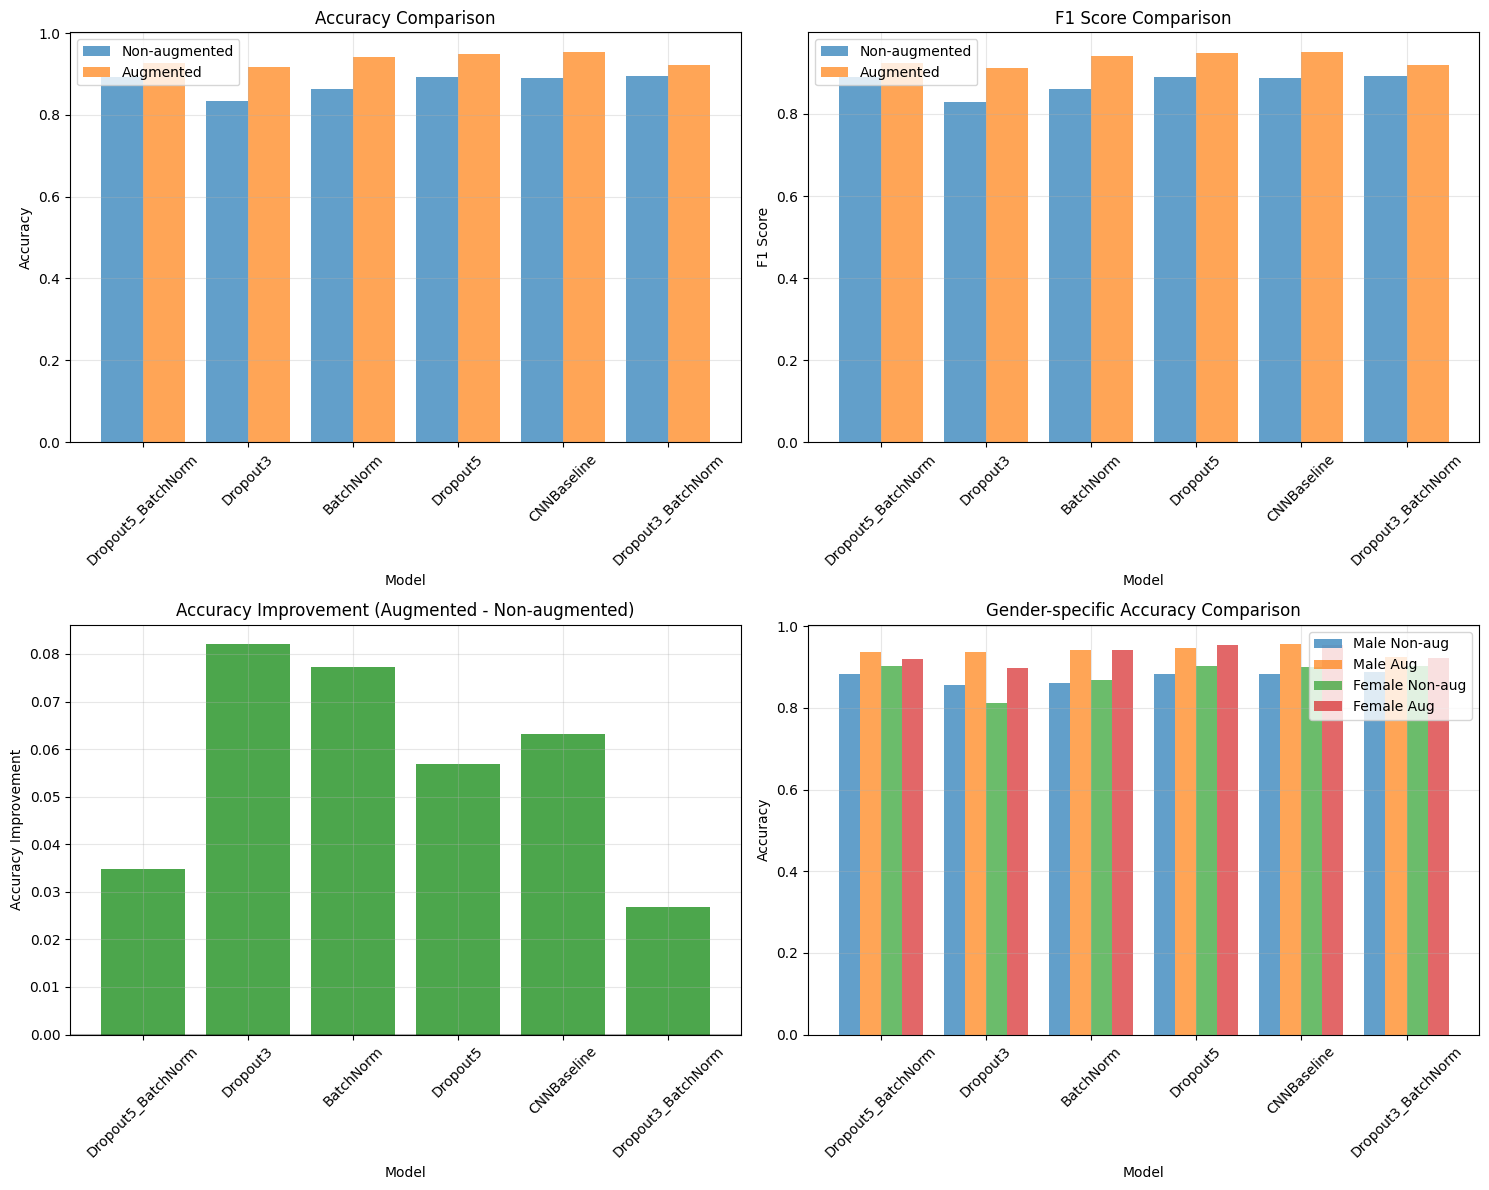


ANALYSIS COMPLETE


In [32]:
import os
import torch
import pandas as pd
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Setup paths and device
base_dir = "/Users/larsheijnen/DL"
non_aug_dir = os.path.join(base_dir, "saved_models", "B", "not_augmented_earlystop")
aug_dir = os.path.join(base_dir, "saved_models", "B", "augmented_earlystop_all_models")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Prepare test dataset for evaluation
test_dataset = AccentSpectrogramDataset(
    '/Users/larsheijnen/DL/Train',
    target_sr=16000,
    use_mel=True,
    n_fft=1024,
    hop_length=256,
    n_mels=64,
    log_scale=True
)

# Split dataset (same split as training for fair comparison)
train_len = int(0.8 * len(test_dataset))
test_len = len(test_dataset) - train_len
_, test_ds = random_split(test_dataset, [train_len, test_len], generator=torch.Generator().manual_seed(42))
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, collate_fn=pad_collate, pin_memory=False)

# Model mapping function
def get_model_class_from_filename(fname):
    if fname.startswith("CNNBaseline_Dropout3_BatchNorm"):
        return CNNBaseline_Dropout3_BatchNorm
    elif fname.startswith("CNNBaseline_Dropout5_BatchNorm"):
        return CNNBaseline_Dropout5_BatchNorm
    elif fname.startswith("CNNBaseline_Dropout3"):
        return CNNBaseline_Dropout3
    elif fname.startswith("CNNBaseline_Dropout5"):
        return CNNBaseline_Dropout5
    elif fname.startswith("CNNBaseline_BatchNorm"):
        return CNNBaseline_BatchNorm
    elif fname.startswith("CNNBaseline"):
        return CNNBaseline
    return None

# Evaluation function
def evaluate_model_comprehensive(model, loader, device):
    model.eval()
    all_preds, all_labels, all_genders = [], [], []
    with torch.no_grad():
        for specs, labels, genders in loader:
            specs, labels = specs.to(device), labels.to(device)
            outputs = model(specs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
            all_genders.extend(genders)
    
    # Overall metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    # Gender-specific metrics
    gender_results = {}
    for gender in ['m', 'f']:
        idxs = [i for i, g in enumerate(all_genders) if g == gender]
        if idxs:
            gender_preds = [all_preds[i] for i in idxs]
            gender_labels = [all_labels[i] for i in idxs]
            gender_acc = accuracy_score(gender_labels, gender_preds)
            gender_results[gender] = gender_acc
        else:
            gender_results[gender] = 0.0
    
    return {
        'accuracy': acc,
        'precision': prec,
        'recall': recall,
        'f1': f1,
        'male_accuracy': gender_results.get('m', 0.0),
        'female_accuracy': gender_results.get('f', 0.0)
    }

# Collect model files
non_aug_files = [f for f in os.listdir(non_aug_dir) if f.endswith(".pth") and "best" in f]
aug_files = [f for f in os.listdir(aug_dir) if f.endswith(".pth") and "best" in f]

print("Found non-augmented models:", non_aug_files)
print("Found augmented models:", aug_files)

# Extract model base names for comparison - FIXED VERSION
def extract_model_name(filename):
    """Extract the base model name from filename - order matters for correct matching"""
    # Check longer names first to avoid partial matches
    if "CNNBaseline_Dropout3_BatchNorm" in filename:
        return "CNNBaseline_Dropout3_BatchNorm"
    elif "CNNBaseline_Dropout5_BatchNorm" in filename:
        return "CNNBaseline_Dropout5_BatchNorm"
    elif "CNNBaseline_Dropout3" in filename:
        return "CNNBaseline_Dropout3"
    elif "CNNBaseline_Dropout5" in filename:
        return "CNNBaseline_Dropout5"
    elif "CNNBaseline_BatchNorm" in filename:
        return "CNNBaseline_BatchNorm"
    elif "CNNBaseline" in filename:
        return "CNNBaseline"
    return None

# Build comparison results
comparison_results = []

# Find matching models - FIXED VERSION
for non_aug_file in non_aug_files:
    model_name = extract_model_name(non_aug_file)
    if model_name is None:
        continue
    
    # Find corresponding augmented model with exact matching
    aug_file = None
    for af in aug_files:
        if extract_model_name(af) == model_name:  # Exact match instead of substring
            aug_file = af
            break
    
    if aug_file is None:
        print(f"No augmented model found for {model_name}")
        continue
    
    print(f"\nComparing {model_name}:")
    print(f"  Non-augmented: {non_aug_file}")
    print(f"  Augmented: {aug_file}")
    
    # Get model class
    model_class = get_model_class_from_filename(non_aug_file)
    if model_class is None:
        print(f"  Could not determine model class for {non_aug_file}")
        continue
    
    # Evaluate non-augmented model
    model = model_class().to(device)
    model.load_state_dict(torch.load(os.path.join(non_aug_dir, non_aug_file), map_location=device))
    non_aug_metrics = evaluate_model_comprehensive(model, test_loader, device)
    
    # Evaluate augmented model
    model = model_class().to(device)
    model.load_state_dict(torch.load(os.path.join(aug_dir, aug_file), map_location=device))
    aug_metrics = evaluate_model_comprehensive(model, test_loader, device)
    
    # Store results
    comparison_results.append({
        'model_name': model_name,
        'non_aug_accuracy': non_aug_metrics['accuracy'],
        'aug_accuracy': aug_metrics['accuracy'],
        'non_aug_precision': non_aug_metrics['precision'],
        'aug_precision': aug_metrics['precision'],
        'non_aug_recall': non_aug_metrics['recall'],
        'aug_recall': aug_metrics['recall'],
        'non_aug_f1': non_aug_metrics['f1'],
        'aug_f1': aug_metrics['f1'],
        'non_aug_male_acc': non_aug_metrics['male_accuracy'],
        'aug_male_acc': aug_metrics['male_accuracy'],
        'non_aug_female_acc': non_aug_metrics['female_accuracy'],
        'aug_female_acc': aug_metrics['female_accuracy'],
        'accuracy_improvement': aug_metrics['accuracy'] - non_aug_metrics['accuracy'],
        'f1_improvement': aug_metrics['f1'] - non_aug_metrics['f1']
    })
    
    print(f"  Non-augmented - Acc: {non_aug_metrics['accuracy']:.4f}, F1: {non_aug_metrics['f1']:.4f}")
    print(f"  Augmented     - Acc: {aug_metrics['accuracy']:.4f}, F1: {aug_metrics['f1']:.4f}")
    print(f"  Improvement   - Acc: {aug_metrics['accuracy'] - non_aug_metrics['accuracy']:.4f}, F1: {aug_metrics['f1'] - non_aug_metrics['f1']:.4f}")

# Create DataFrame for easy analysis
if comparison_results:
    df_results = pd.DataFrame(comparison_results)
    print("\n" + "="*80)
    print("COMPARISON SUMMARY")
    print("="*80)
    print(df_results.round(4))

    # Summary statistics
    print(f"\nOverall Statistics:")
    print(f"Average accuracy improvement: {df_results['accuracy_improvement'].mean():.4f} ± {df_results['accuracy_improvement'].std():.4f}")
    print(f"Average F1 improvement: {df_results['f1_improvement'].mean():.4f} ± {df_results['f1_improvement'].std():.4f}")
    print(f"Models with improved accuracy: {(df_results['accuracy_improvement'] > 0).sum()}/{len(df_results)}")
    print(f"Models with improved F1: {(df_results['f1_improvement'] > 0).sum()}/{len(df_results)}")

    # Find best models
    best_non_aug = df_results.loc[df_results['non_aug_accuracy'].idxmax()]
    best_aug = df_results.loc[df_results['aug_accuracy'].idxmax()]
    most_improved = df_results.loc[df_results['accuracy_improvement'].idxmax()]

    print(f"\nBest non-augmented model: {best_non_aug['model_name']} (Acc: {best_non_aug['non_aug_accuracy']:.4f})")
    print(f"Best augmented model: {best_aug['model_name']} (Acc: {best_aug['aug_accuracy']:.4f})")
    print(f"Most improved model: {most_improved['model_name']} (Improvement: {most_improved['accuracy_improvement']:.4f})")

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Accuracy comparison
    x_pos = range(len(df_results))
    axes[0,0].bar([x - 0.2 for x in x_pos], df_results['non_aug_accuracy'], 0.4, label='Non-augmented', alpha=0.7)
    axes[0,0].bar([x + 0.2 for x in x_pos], df_results['aug_accuracy'], 0.4, label='Augmented', alpha=0.7)
    axes[0,0].set_xlabel('Model')
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].set_title('Accuracy Comparison')
    axes[0,0].set_xticks(x_pos)
    axes[0,0].set_xticklabels([name.replace('CNNBaseline_', '') for name in df_results['model_name']], rotation=45)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # F1 comparison
    axes[0,1].bar([x - 0.2 for x in x_pos], df_results['non_aug_f1'], 0.4, label='Non-augmented', alpha=0.7)
    axes[0,1].bar([x + 0.2 for x in x_pos], df_results['aug_f1'], 0.4, label='Augmented', alpha=0.7)
    axes[0,1].set_xlabel('Model')
    axes[0,1].set_ylabel('F1 Score')
    axes[0,1].set_title('F1 Score Comparison')
    axes[0,1].set_xticks(x_pos)
    axes[0,1].set_xticklabels([name.replace('CNNBaseline_', '') for name in df_results['model_name']], rotation=45)
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Improvement bar chart
    improvements = df_results['accuracy_improvement']
    colors = ['green' if x > 0 else 'red' for x in improvements]
    axes[1,0].bar(x_pos, improvements, color=colors, alpha=0.7)
    axes[1,0].set_xlabel('Model')
    axes[1,0].set_ylabel('Accuracy Improvement')
    axes[1,0].set_title('Accuracy Improvement (Augmented - Non-augmented)')
    axes[1,0].set_xticks(x_pos)
    axes[1,0].set_xticklabels([name.replace('CNNBaseline_', '') for name in df_results['model_name']], rotation=45)
    axes[1,0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[1,0].grid(True, alpha=0.3)
    
    # Gender-specific accuracy comparison
    male_non_aug = df_results['non_aug_male_acc'].values
    male_aug = df_results['aug_male_acc'].values
    female_non_aug = df_results['non_aug_female_acc'].values
    female_aug = df_results['aug_female_acc'].values
    
    x_pos_gender = range(len(df_results))
    width = 0.2
    axes[1,1].bar([x - 1.5*width for x in x_pos_gender], male_non_aug, width, label='Male Non-aug', alpha=0.7)
    axes[1,1].bar([x - 0.5*width for x in x_pos_gender], male_aug, width, label='Male Aug', alpha=0.7)
    axes[1,1].bar([x + 0.5*width for x in x_pos_gender], female_non_aug, width, label='Female Non-aug', alpha=0.7)
    axes[1,1].bar([x + 1.5*width for x in x_pos_gender], female_aug, width, label='Female Aug', alpha=0.7)
    
    axes[1,1].set_xlabel('Model')
    axes[1,1].set_ylabel('Accuracy')
    axes[1,1].set_title('Gender-specific Accuracy Comparison')
    axes[1,1].set_xticks(x_pos_gender)
    axes[1,1].set_xticklabels([name.replace('CNNBaseline_', '') for name in df_results['model_name']], rotation=45)
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No matching models found for comparison!")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

## Predicting accent on Test data (to submit)

### FINAL Predicting acccent on Test data with the best augmented models
This code loads a separate test dataset of accent spectrograms from a specified folder using the same preprocessing settings as training, creating a test_loader to batch the data for evaluation without shuffling. This allows for consistent, reproducible testing of model performance on new, unseen data. This is on the best models.

In [22]:
testset_folder = "/Users/larsheijnen/DL/Test set"
test_dataset = AccentSpectrogramDataset(
    testset_folder,
    target_sr=16000,
    use_mel=True,
    n_fft=1024,
    hop_length=256,
    n_mels=64,
    log_scale=True
)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=pad_collate)

This code dynamically sets the directory containing saved model weights (.pth files), lists all saved model files in that directory, and creates a mapping from each filename to its corresponding model class by checking the filename prefix.

In [23]:
import os
import torch

# Dynamically determine the saved models directory relative to this script or notebook
base_dir = os.path.dirname(os.path.abspath('assignment__b_latest-2.ipynb'))  # or __file__ if in .py
saved_models_dir = os.path.join(base_dir, "saved_models", "B", "augmented_earlystop_all_models")

# List all .pth files in the directory that contain "best"
model_files = [f for f in os.listdir(saved_models_dir) if f.endswith(".pth") and "best" in f]

# Map model file names to their classes (assumes naming convention: class name is prefix before first underscore or before '_latest')
model_classes = {}
for fname in model_files:
    if fname.startswith("CNNBaseline_Dropout3_BatchNorm"):
        model_classes[fname] = CNNBaseline_Dropout3_BatchNorm
    elif fname.startswith("CNNBaseline_Dropout5_BatchNorm"):
        model_classes[fname] = CNNBaseline_Dropout5_BatchNorm
    elif fname.startswith("CNNBaseline_Dropout3"):
        model_classes[fname] = CNNBaseline_Dropout3
    elif fname.startswith("CNNBaseline_Dropout5"):
        model_classes[fname] = CNNBaseline_Dropout5
    elif fname.startswith("CNNBaseline_BatchNorm"):
        model_classes[fname] = CNNBaseline_BatchNorm
    elif fname.startswith("CNNBaseline"):
        model_classes[fname] = CNNBaseline



This function predicts accent classes for each sample in the test set by passing batches through the model and collecting the predicted labels along with their corresponding filenames. It returns a list of tuples, where each tuple contains a filename and its predicted accent class.

In [24]:
def predict_accent_on_testset(model, test_loader, device):
    model.eval()
    all_preds = []
    all_fnames = []
    with torch.no_grad():
        for i, (specs, _, _) in enumerate(test_loader):  # gender is ignored
            specs = specs.to(device)
            outputs = model(specs)
            preds = outputs.argmax(dim=1).cpu().tolist()
            all_preds.extend(preds)
            # Get filenames for this batch
            batch_indices = range(i * test_loader.batch_size, i * test_loader.batch_size + len(preds))
            fnames = [os.path.basename(test_dataset.file_paths[idx]) for idx in batch_indices]
            all_fnames.extend(fnames)
    return list(zip(all_fnames, all_preds))

In [25]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Ensure the result directory exists
result_dir = os.path.join(base_dir, "result")
os.makedirs(result_dir, exist_ok=True)

for model_file, model_class in model_classes.items():
    model = model_class().to(device)
    model_path = os.path.join(saved_models_dir, model_file)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print(f"\nGenerating submission file for model: {model_file}")
    results = predict_accent_on_testset(model, test_loader, device)
    
    # Prepare submission lines
    submission_lines = ["Id,label"]
    for fname, pred in results:
        # Extract the numeric ID from the filename (e.g., 1023 from 1023.wav)
        file_id = os.path.splitext(fname)[0]
        submission_lines.append(f"{file_id},{pred+1}")  # Increase label by 1
    
    # Write to submission file in the result directory
    submission_filename = f"submission_{os.path.splitext(model_file)[0]}.csv"
    submission_path = os.path.join(result_dir, submission_filename)
    with open(submission_path, "w") as f:
        f.write("\n".join(submission_lines))
    print(f"Submission file saved as: {submission_path}")


Generating submission file for model: CNNBaseline_Dropout5_best.pth
Submission file saved as: /Users/larsheijnen/DL/result/submission_CNNBaseline_Dropout5_best.csv

Generating submission file for model: CNNBaseline_Dropout3_BatchNorm_best.pth
Submission file saved as: /Users/larsheijnen/DL/result/submission_CNNBaseline_Dropout3_BatchNorm_best.csv

Generating submission file for model: CNNBaseline_Dropout5_BatchNorm_best.pth
Submission file saved as: /Users/larsheijnen/DL/result/submission_CNNBaseline_Dropout5_BatchNorm_best.csv

Generating submission file for model: CNNBaseline_best.pth
Submission file saved as: /Users/larsheijnen/DL/result/submission_CNNBaseline_best.csv

Generating submission file for model: CNNBaseline_Dropout3_best.pth
Submission file saved as: /Users/larsheijnen/DL/result/submission_CNNBaseline_Dropout3_best.csv

Generating submission file for model: CNNBaseline_BatchNorm_best.pth
Submission file saved as: /Users/larsheijnen/DL/result/submission_CNNBaseline_Batch

### FINAL Predicting acccent on Test data with the best non- augmented models
This code loads a separate test dataset of accent spectrograms from a specified folder using the same preprocessing settings as training, creating a test_loader to batch the data for evaluation without shuffling. This allows for consistent, reproducible testing of model performance on new, unseen data. This is on the best models.

In [26]:
testset_folder = "/Users/larsheijnen/DL/Test set"
test_dataset = AccentSpectrogramDataset(
    testset_folder,
    target_sr=16000,
    use_mel=True,
    n_fft=1024,
    hop_length=256,
    n_mels=64,
    log_scale=True
)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=pad_collate)

In [27]:
import os
import torch

# Dynamically determine the saved models directory relative to this script or notebook
base_dir = os.path.dirname(os.path.abspath('assignment__b_latest-2.ipynb'))  # or __file__ if in .py
saved_models_dir = os.path.join(base_dir, "saved_models", "B", "augmented_earlystop_all_models")

# List all .pth files in the directory that contain "best"
model_files = [f for f in os.listdir(saved_models_dir) if f.endswith(".pth") and "best" in f]

# Map model file names to their classes (assumes naming convention: class name is prefix before first underscore or before '_latest')
model_classes = {}
for fname in model_files:
    if fname.startswith("CNNBaseline_Dropout3_BatchNorm"):
        model_classes[fname] = CNNBaseline_Dropout3_BatchNorm
    elif fname.startswith("CNNBaseline_Dropout5_BatchNorm"):
        model_classes[fname] = CNNBaseline_Dropout5_BatchNorm
    elif fname.startswith("CNNBaseline_Dropout3"):
        model_classes[fname] = CNNBaseline_Dropout3
    elif fname.startswith("CNNBaseline_Dropout5"):
        model_classes[fname] = CNNBaseline_Dropout5
    elif fname.startswith("CNNBaseline_BatchNorm"):
        model_classes[fname] = CNNBaseline_BatchNorm
    elif fname.startswith("CNNBaseline"):
        model_classes[fname] = CNNBaseline


def predict_accent_on_testset(model, test_loader, device):
    model.eval()
    all_preds = []
    all_fnames = []
    with torch.no_grad():
        for i, (specs, _, _) in enumerate(test_loader):  # gender is ignored
            specs = specs.to(device)
            outputs = model(specs)
            preds = outputs.argmax(dim=1).cpu().tolist()
            all_preds.extend(preds)
            # Get filenames for this batch
            batch_indices = range(i * test_loader.batch_size, i * test_loader.batch_size + len(preds))
            fnames = [os.path.basename(test_dataset.file_paths[idx]) for idx in batch_indices]
            all_fnames.extend(fnames)
    return list(zip(all_fnames, all_preds))



device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Ensure the result directory exists
result_dir = os.path.join(base_dir, "result")
os.makedirs(result_dir, exist_ok=True)

for model_file, model_class in model_classes.items():
    model = model_class().to(device)
    model_path = os.path.join(saved_models_dir, model_file)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print(f"\nGenerating submission file for model: {model_file}")
    results = predict_accent_on_testset(model, test_loader, device)
    
    # Prepare submission lines
    submission_lines = ["Id,label"]
    for fname, pred in results:
        # Extract the numeric ID from the filename (e.g., 1023 from 1023.wav)
        file_id = os.path.splitext(fname)[0]
        submission_lines.append(f"{file_id},{pred+1}")  # Increase label by 1
    
    # Write to submission file in the result directory
    submission_filename = f"submission_not-augmented_data{os.path.splitext(model_file)[0]}.csv"
    submission_path = os.path.join(result_dir, submission_filename)
    with open(submission_path, "w") as f:
        f.write("\n".join(submission_lines))
    print(f"Submission file saved as: {submission_path}")


Generating submission file for model: CNNBaseline_Dropout5_best.pth
Submission file saved as: /Users/larsheijnen/DL/result/submission_not-augmented_dataCNNBaseline_Dropout5_best.csv

Generating submission file for model: CNNBaseline_Dropout3_BatchNorm_best.pth
Submission file saved as: /Users/larsheijnen/DL/result/submission_not-augmented_dataCNNBaseline_Dropout3_BatchNorm_best.csv

Generating submission file for model: CNNBaseline_Dropout5_BatchNorm_best.pth
Submission file saved as: /Users/larsheijnen/DL/result/submission_not-augmented_dataCNNBaseline_Dropout5_BatchNorm_best.csv

Generating submission file for model: CNNBaseline_best.pth
Submission file saved as: /Users/larsheijnen/DL/result/submission_not-augmented_dataCNNBaseline_best.csv

Generating submission file for model: CNNBaseline_Dropout3_best.pth
Submission file saved as: /Users/larsheijnen/DL/result/submission_not-augmented_dataCNNBaseline_Dropout3_best.csv

Generating submission file for model: CNNBaseline_BatchNorm_be